group,log_month,high,low,mid
0,low,-0.379526,0.001106,-0.246957
1,mid,5.128571,-0.015915,4.063014
2,high,15.870046,-0.045170,9.514892


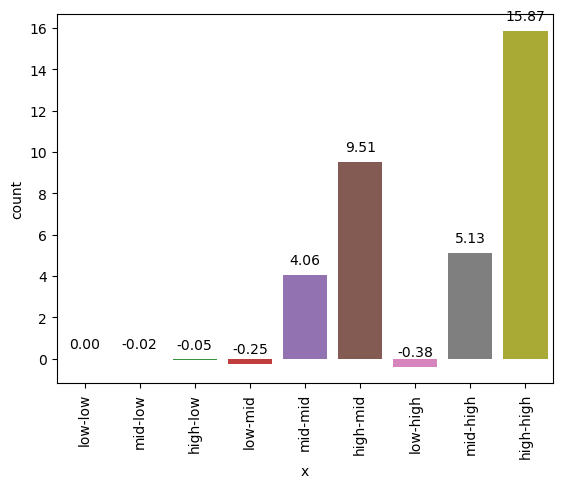

In [1]:
import numpy as np
import pandas as pd
import os

def read_fun(path, folder, subfolder = "game-01"):
    data_folder_path = path + "/" + folder + "/" + subfolder
    folder_list = os.listdir(data_folder_path)
    data_list = []
    for name in folder_list:
        data_path = data_folder_path + "/" + name + "/" + "data.tsv"
        data = pd.read_table(data_path, sep = "\t", header = 0)
        data_list.append(data)
    
    res_data = pd.concat(data_list, axis = 0, ignore_index = True)
    return(res_data)


dau = read_fun(path = "./data/game_user_data",
               folder = "dau",
               subfolder = "game-01")

dpu = read_fun(path = "./data/game_user_data",
               folder = "dpu",
               subfolder = "game-01")

dau.head()
dpu.head()

data = pd.merge(dau, dpu, on = ["log_date", "app_name", "user_id"], how = "left")
data.loc[data.payment.isna(), "payment"] = 0

data["log_date"] = pd.to_datetime(data.log_date,
                                  format = "%Y-%m-%d")

data.log_date.dt.month
data["month"] = data.log_date.dt.month
data.groupby("month").apply(lambda x : len(x.user_id.unique()))

data2 = data.groupby(["month", "user_id"]).agg(log_month = ("log_date", lambda x : x.shape[0]), pay_month = ("payment", "mean"))
data2.reset_index(drop = False, inplace = True)

log_vs_pay = data2.groupby("user_id").agg({"log_month" :
                                           lambda x : str(np.where((x>15).all(), "high",
                                                                   np.where((x>10).all(), "mid", "low"))),
                                           "pay_month" : 
                                               lambda x :str(np.where((x>100).any(), "high", np.where((x>50).any(), "mid", "low")))})
    
pd.crosstab(log_vs_pay.log_month,
                          log_vs_pay.pay_month)

log_vs_pay["log_month"] = pd.Categorical(log_vs_pay["log_month"],
                                             categories = ["low", "mid", "high"])
log_vs_pay["pay_month"] = pd.Categorical(log_vs_pay["pay_month"],
                                             categories = ["low", "mid", "high"])
ct = pd.crosstab(log_vs_pay.log_month,
                          log_vs_pay.pay_month)

cp = ct.sum(axis = 0) / ct.values.sum() #행방향 sum


rp = ct.sum(axis = 1) / ct.values.sum()

np.outer(rp, cp) 
et = ct.values.sum() * np.outer(rp, cp) 

diff = (ct - et) / et 
diff_dat = diff.copy()
diff_dat.reset_index(drop = False,
                      inplace = True)
diff_melt = diff_dat.melt(id_vars = "log_month",
                          value_vars = ["low", "mid", "high"],
                          var_name = "group",
                          value_name = "count")
diff_melt["x"] = diff_melt.log_month.astype(str) + "-" + diff_melt.group

import seaborn as sns
axes = sns.barplot(x = "x", y = "count", data = diff_melt)
axes.tick_params(axis = "x", labelrotation = 90)
for patch in axes.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() + 0.5
    axes.text(x, y,
              s = "%.2f" % (patch.get_height()),
              ha = "center")
    
diff_melt.pivot_table(index = "log_month",
                      columns = "group",
                      values = "count").reset_index(drop = False)